# TP 4: Système de Recommandation de Films

*Pr*: DIB BRAHIM  
*Filière*: CIA
*Année Universitaire*: 2025/2026
*Nom Complet*: ANASS EL YOUSFI 

# A 1. Explorer des données

   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

Statistiques descriptives :
              userId        movieId         rating     timestamp
count  100836.000000  100836.000000  100836.000000  1.008360e+05
mean      326.1275

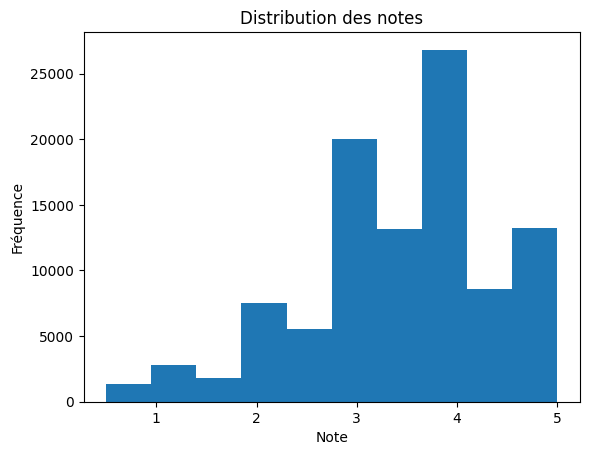

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

ratings = pd.read_csv("ratings.csv")
movies = pd.read_csv("movies.csv")

print(ratings.head())
print(movies.head())

print("\nStatistiques descriptives :")
print(ratings.describe())

print("Utilisateurs :", ratings["userId"].nunique())
print("Films :", ratings["movieId"].nunique())

plt.hist(ratings["rating"], bins=10)
plt.xlabel("Note")
plt.ylabel("Fréquence")
plt.title("Distribution des notes")
plt.show()

# A 2. Prétraiter les données

In [3]:
ratings = ratings.dropna()
movies = movies.dropna()

ratings = ratings.drop_duplicates()
movies = movies.drop_duplicates()


data = pd.merge(ratings, movies, on="movieId")


user_counts = data["userId"].value_counts()
active_users = user_counts[user_counts >= 20].index
data = data[data["userId"].isin(active_users)]


movie_counts = data["movieId"].value_counts()
popular_movies = movie_counts[movie_counts >= 20].index
data = data[data["movieId"].isin(popular_movies)]

print("Données après filtrage :", data.shape)

Données après filtrage : (67898, 6)


# A 3. MODÉLISATION

In [6]:
# ---------- 1. Recommandation par popularité ----------
def RecommandationParPopularite(df, top_n=10, min_ratings=4):
    popularity = (
        df.groupby('title')
        .agg(
            mean_rating=('rating', 'mean'),
            rating_count=('rating', 'count'),
        )
        .reset_index()
    )


    popularity = popularity[popularity['rating_count'] >= min_ratings]


    popularity = popularity.sort_values(
        by=['rating_count', 'mean_rating'],
        ascending=False
    )

    return popularity.head(top_n)
    

print(RecommandationParPopularite(data ,10))

                                          title  mean_rating  rating_count
433                         Forrest Gump (1994)     4.164134           329
1015           Shawshank Redemption, The (1994)     4.429022           317
909                         Pulp Fiction (1994)     4.197068           307
1030           Silence of the Lambs, The (1991)     4.161290           279
733                          Matrix, The (1999)     4.192446           278
1090  Star Wars: Episode IV - A New Hope (1977)     4.231076           251
628                        Jurassic Park (1993)     3.750000           238
182                           Braveheart (1995)     4.031646           237
1134          Terminator 2: Judgment Day (1991)     3.970982           224
990                     Schindler's List (1993)     4.225000           220


In [8]:
# ---------- 2. Filtrage collaboratif (Item-Based) ----------
user_movie_matrix = data.pivot_table(
    index="userId",
    columns="title",
    values="rating"
).fillna(0)

item_similarity = cosine_similarity(user_movie_matrix.T)
item_similarity_df = pd.DataFrame(
    item_similarity,
    index=user_movie_matrix.columns,
    columns=user_movie_matrix.columns
)
def recommend_item_based(user_id, n=5):
    user_ratings = user_movie_matrix.loc[user_id]
    liked_movies = user_ratings[user_ratings >= 4].index

    scores = item_similarity_df[liked_movies].sum(axis=1)
    scores = scores.drop(liked_movies)

    return scores.sort_values(ascending=False).head(n)
print( recommend_item_based(1, n=5))

title
Ferris Bueller's Day Off (1986)     62.663506
Men in Black (a.k.a. MIB) (1997)    61.911993
Die Hard (1988)                     58.938573
Breakfast Club, The (1985)          58.588244
Fifth Element, The (1997)           58.124929
dtype: float64


In [10]:
# ---------- 3. Option avancée : SVD  ----------
svd = TruncatedSVD(n_components=20, random_state=42)
latent_matrix = svd.fit_transform(user_movie_matrix)

predicted_ratings = np.dot(latent_matrix, svd.components_)
predicted_ratings_df = pd.DataFrame(
    predicted_ratings,
    index=user_movie_matrix.index,
    columns=user_movie_matrix.columns
)
print(predicted_ratings_df)


title   (500) Days of Summer (2009)  10 Things I Hate About You (1999)  \
userId                                                                   
1                         -0.913604                           0.219885   
2                          0.189454                          -0.026082   
3                         -0.015628                          -0.020888   
4                          0.088095                           1.234048   
5                         -0.106470                           0.006950   
...                             ...                                ...   
606                        1.649571                           2.450015   
607                       -0.209589                           0.033569   
608                       -0.130158                           1.663221   
609                        0.005215                          -0.067520   
610                        3.281068                           1.025825   

title   101 Dalmatians (1996)  \
user

# A 4. SÉPARATION TRAIN / TEST

In [ ]:
train_data, test_data = train_test_split(
    data, test_size=0.2, random_state=42
)

# A 5. ÉVALUATION DU MODÈLE (RMSE / MAE)

In [ ]:
# 1️ Évaluation Recommandation par Popularité
print("\n=== Évaluation Recommandation par Popularité ===")
top_popular = RecommandationParPopularite(data, top_n=10)
print(top_popular[['title', 'mean_rating', 'rating_count']])

In [ ]:
# 2️ Évaluation Filtrage collaboratif Item-Based 
print("\n=== Évaluation Filtrage collaboratif (Item-Based) ===")
y_true_item = []
y_pred_item = []

for _, row in test_data.iterrows():
    user = row["userId"]
    movie = row["title"]

    if movie in item_similarity_df.columns and user in user_movie_matrix.index:
        user_ratings = user_movie_matrix.loc[user]
        liked_movies = user_ratings[user_ratings >= 4].index

        if len(liked_movies) > 0:

            sim_scores = item_similarity_df.loc[movie, liked_movies]
            ratings = user_ratings[liked_movies]
            if sim_scores.sum() > 0:
                pred = np.dot(sim_scores, ratings) / sim_scores.sum()
            else:
                pred = ratings.mean()

            y_pred_item.append(pred)
            y_true_item.append(row["rating"])


if len(y_pred_item) > 0:
    rmse_item = np.sqrt(mean_squared_error(y_true_item, y_pred_item))
    mae_item = mean_absolute_error(y_true_item, y_pred_item)
    print("RMSE Item-Based :", rmse_item)
    print("MAE Item-Based  :", mae_item)
else:
    print("Pas assez de données pour calculer RMSE/MAE Item-Based")


In [ ]:
print("\n=== Évaluation SVD ===")
y_true_svd = []
y_pred_svd = []

for _, row in test_data.iterrows():
    user = row["userId"]
    movie = row["title"]
    if user in predicted_ratings_df.index and movie in predicted_ratings_df.columns:
        y_true_svd.append(row["rating"])
        y_pred_svd.append(predicted_ratings_df.loc[user, movie])

rmse_svd = np.sqrt(mean_squared_error(y_true_svd, y_pred_svd))
mae_svd = mean_absolute_error(y_true_svd, y_pred_svd)

print("RMSE SVD :", rmse_svd)
print("MAE SVD  :", mae_svd)

        

# A 6. RECOMMANDATION TOP-N

In [ ]:
def recommend_svd(user_id, n=5):
    user_predictions = predicted_ratings_df.loc[user_id]
    already_seen = user_movie_matrix.loc[user_id]
    user_predictions = user_predictions[already_seen == 0]
    return user_predictions.sort_values(ascending=False).head(n)

print("\nRecommandation Item-Based (User 1) :")
print(recommend_item_based(user_id=1, n=5))

print("\nRecommandation SVD (User 1) :")
print(recommend_svd(user_id=1, n=5))

#  API

In [ ]:
from flask import Flask, request, jsonify, render_template
from flask_cors import CORS

app = Flask(__name__)
CORS(app)

@app.route('/')
def index():
    return render_template('index.html')

@app.route('/recommend')
def recommend():
    try:
        user_id = int(request.args.get('user_id'))
        algo = request.args.get('algo')

        if algo == "item":
            recs = recommend_item_based(user_id).index.tolist()
        else:
            recs = recommend_svd(user_id).index.tolist()

        return jsonify({"recommendations": recs})
    except Exception as e:
        return jsonify({"error": str(e)}), 400

if __name__ == "__main__":
    app.run(debug=True)